# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV93"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv93')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv93/lv93-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 16:07:47,642 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP055569, SRP042161, SRP033135, SRP050499, SRP057196, SRP060416, SRP007947, SRP066834, SRP058773, SRP025982, SRP024268, SRP055810, SRP017777, SRP007596, SRP059775, SRP000599, SRP009266, SRP014428, SRP055153, SRP022892, SRP049500, SRP006575, SRP019994, SRP056696, SRP003726, SRP059379, SRP063840, SRP056835, SRP018716, SRP018525, SRP007461, SRP059035, SRP007569, SRP050272, SRP028887, SRP033248, SRP059732, SRP009276, SRP058120, SRP005279, SRP034712, SRP050493, SRP052874, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (41 != 43)
  warnings.warn(


In [19]:
lv_data.shape

(7446, 75)

In [20]:
lv_data.head()

cell type cell line patient id  \
project   run                                                                 
SRP055569 SRR1821717  MCF10a human breast cancer cells       NaN        NaN   
          SRR1821716  MCF10a human breast cancer cells       NaN        NaN   
          SRR1821715  MCF10a human breast cancer cells       NaN        NaN   
          SRR1821714  MCF10a human breast cancer cells       NaN        NaN   
          SRR1821713  MCF10a human breast cancer cells       NaN        NaN   

                     subtype hour post serum-switch debris control well  \
project   run                                                             
SRP055569 SRR1821717     NaN                    NaN    NaN          NaN   
          SRR1821716     NaN                    NaN    NaN          NaN   
          SRR1821715     NaN                    NaN    NaN          NaN   
          SRR1821714     NaN                    NaN    NaN          NaN   
          SRR1821713     NaN                    NaN    NaN          NaN   

                     cells in well library protocol developmental stage  ...  \
project   run                                                            ...   
SRP055569 SRR1821717           NaN              NaN                 NaN  ...   
          SRR1821716           NaN              NaN                 NaN  ...   
          SRR1821715           NaN              NaN                 NaN  ...   
          SRR1821714           NaN              NaN                 NaN  ...   
          SRR1821713           NaN              NaN                 NaN  ...   

                     dicer knockdown all lineage bcp all subtype  \
project   run                                                      
SRP055569 SRR1821717             NaN         NaN             NaN   
          SRR1821716             NaN         NaN             NaN   
          SRR1821715             NaN         NaN             NaN   
          SRR1821714             NaN         NaN             NaN   
          SRR1821713             NaN         NaN             NaN   

                     cytogenetic background starting material differentiation  \
project   run                                                                   
SRP055569 SRR1821717                    NaN               NaN             NaN   
          SRR1821716                    NaN               NaN             NaN   
          SRR1821715                    NaN               NaN             NaN   
          SRR1821714                    NaN               NaN             NaN   
          SRR1821713                    NaN               NaN             NaN   

                     sorting# scrb-seq variant# time point      LV93  
project   run                                                         
SRP055569 SRR1821717      NaN               NaN        NaN  0.141422  
          SRR1821716      NaN               NaN        NaN  0.008773  
          SRR1821715      NaN               NaN        NaN  0.144899  
          SRR1821714      NaN               NaN        NaN -0.042579  
          SRR1821713      NaN               NaN        NaN  0.046482  

[5 rows x 75 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cell type                         0.057962
antibodies                        0.008130
origin                            0.008130
reprogramming time point (day)    0.003157
well number                       0.003157
tnm                               0.003144
transfection                      0.002843
cancer or normal                  0.002809
culture medium                    0.002374
c1 chip id                        0.001964
experiment_sample_name            0.001964
age                               0.001817
facs gating                       0.001756
tonsil donor                      0.001756
Stage                             0.001547
time                              0.001465
tissue                            0.001409
reprogramming vector              0.001308
iPSc                              0.001308
cell type subset                  0.001274
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type         0.057962
tissue            0.001409
cell line/type    0.000447
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "cell line/type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[3]

cell type  \
project   run                                                             
SRP055569 SRR1821376                             U87 human glioma cells   
          SRR1821596  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821692                   MCF10a human breast cancer cells   
SRP033135 SRR1033249             Human Skeletal Muscle Myoblasts (HSMM)   
SRP066834 SRR2967800                                                NaN   
SRP060416 SRR2088609                       tonsil Innate lymphoid cells   
SRP055569 SRR1821392                             U87 human glioma cells   
SRP058773 SRR2042614                                                NaN   
SRP055569 SRR1821614  mixture of U87 human glioma cells and MCF10a h...   
SRP042161 SRR1295307                             Gliomasphere Cell Line   
SRP055569 SRR1821522  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821715                   MCF10a human breast cancer cells   
          SRR1821637                   MCF10a human breast cancer cells   
SRP066834 SRR2967819                                                NaN   
SRP055569 SRR1821717                   MCF10a human breast cancer cells   
SRP060416 SRR2088285                       tonsil Innate lymphoid cells   
          SRR2088310                       tonsil Innate lymphoid cells   
SRP057196 SRR1974901                                    fetal_quiescent   
SRP055569 SRR1821531  mixture of U87 human glioma cells and MCF10a h...   
SRP066834 SRR2967743                                                NaN   
SRP060416 SRR2088477                       tonsil Innate lymphoid cells   
SRP055569 SRR1821378                             U87 human glioma cells   
          SRR1821519  mixture of U87 human glioma cells and MCF10a h...   
SRP017777 SRR644275                                                 NaN   
SRP055569 SRR1821677                   MCF10a human breast cancer cells   

                               tissue cell line/type      LV93  
project   run                                                   
SRP055569 SRR1821376              NaN            NaN  0.155853  
          SRR1821596              NaN            NaN  0.154973  
          SRR1821692              NaN            NaN  0.154880  
SRP033135 SRR1033249              NaN            NaN  0.154715  
SRP066834 SRR2967800  Fetal neocortex            NaN  0.154398  
SRP060416 SRR2088609              NaN            NaN  0.151731  
SRP055569 SRR1821392              NaN            NaN  0.151093  
SRP058773 SRR2042614              NaN            NaN  0.149452  
SRP055569 SRR1821614              NaN            NaN  0.147908  
SRP042161 SRR1295307              NaN            NaN  0.147714  
SRP055569 SRR1821522              NaN            NaN  0.147680  
          SRR1821715              NaN            NaN  0.144899  
          SRR1821637              NaN            NaN  0.143266  
SRP066834 SRR2967819  Fetal neocortex            NaN  0.141749  
SRP055569 SRR1821717              NaN            NaN  0.141422  
SRP060416 SRR2088285              NaN            NaN  0.139748  
          SRR2088310              NaN            NaN  0.139270  
SRP057196 SRR1974901           cortex            NaN  0.139193  
SRP055569 SRR1821531              NaN            NaN  0.138566  
SRP066834 SRR2967743  Fetal neocortex            NaN  0.138279  
SRP060416 SRR2088477              NaN            NaN  0.138027  
SRP055569 SRR1821378              NaN            NaN  0.137080  
          SRR1821519              NaN            NaN  0.135248  
SRP017777 SRR644275   Temporal cortex            NaN  0.135240  
SRP055569 SRR1821677              NaN            NaN  0.133153

In [26]:
# what is there in these projects?
lv_data.loc[["SRP058773"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

well number reprogramming time point (day)      LV93
project   run                                                            
SRP058773 SRR2042658          67                             10  0.232938
          SRR2042618          14                             10  0.201926
          SRR2042614          23                             10  0.149452
          SRR2042613          76                             10  0.115782
          SRR2042646          48                             10  0.075303
          SRR2042610          41                             10  0.066753
          SRR2042616          61                             10  0.064327
          SRR2042649          73                             10  0.058538
          SRR2042624          20                             10  0.055665
          SRR2042630          21                             10  0.047760

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "cell line/type"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP055569 SRR1821580  mixture of U87 human glioma cells and MCF10a h...   
          SRR2019156  mixture of U87 human glioma cells and WI-38 hu...   
          SRR2019090                  WI-38 human lung fibroblast cells   
          SRR2019185  mixture of U87 human glioma cells and WI-38 hu...   
SRP042161 SRR1294848                                       Glioblastoma   
SRP033135 SRR1033035             Human Skeletal Muscle Myoblasts (HSMM)   
SRP055569 SRR2019221  mixture of U87 human glioma cells and WI-38 hu...   
          SRR2019126  mixture of U87 human glioma cells and WI-38 hu...   
SRP050499 SRR2013757                                    NOT CATEGORIZED   
SRP055569 SRR1821374                             U87 human glioma cells   
          SRR2019037                             U87 human glioma cells   
          SRR2018983  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821497  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821487  mixture of U87 human glioma cells and MCF10a h...   
SRP057196 SRR1974603                                            neurons   
SRP055569 SRR1821611  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821602  mixture of U87 human glioma cells and MCF10a h...   
SRP060416 SRR2088252                       tonsil Innate lymphoid cells   
SRP055569 SRR1821489  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821470  mixture of U87 human glioma cells and MCF10a h...   

                           LV93  
project   run                    
SRP055569 SRR1821580  13.972951  
          SRR2019156   0.703623  
          SRR2019090   0.681809  
          SRR2019185   0.494218  
SRP042161 SRR1294848   0.490596  
SRP033135 SRR1033035   0.479438  
SRP055569 SRR2019221   0.468346  
          SRR2019126   0.445295  
SRP050499 SRR2013757   0.401492  
SRP055569 SRR1821374   0.396155  
          SRR2019037   0.374174  
          SRR2018983   0.366901  
          SRR1821497   0.360615  
          SRR1821487   0.342811  
SRP057196 SRR1974603   0.341721  
SRP055569 SRR1821611   0.339173  
          SRR1821602   0.332277  
SRP060416 SRR2088252   0.316689  
SRP055569 SRR1821489   0.299190  
          SRR1821470   0.295681

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # SRP057196
            "fetal_quiescent": "Fetal neurons (quiescent)",
            "fetal_replicating": "Fetal neurons (replicating)",
            # SRP055569
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

In [34]:
# # add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-26d4d9c15426>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['Glioma cells + breast cancer cells',
 'Glioma cells + lung fibroblast cells',
 'WI-38 human lung fibroblast cells',
 'Glioblastoma',
 'Human Skeletal Muscle Myoblasts (HSMM)']

## Plot

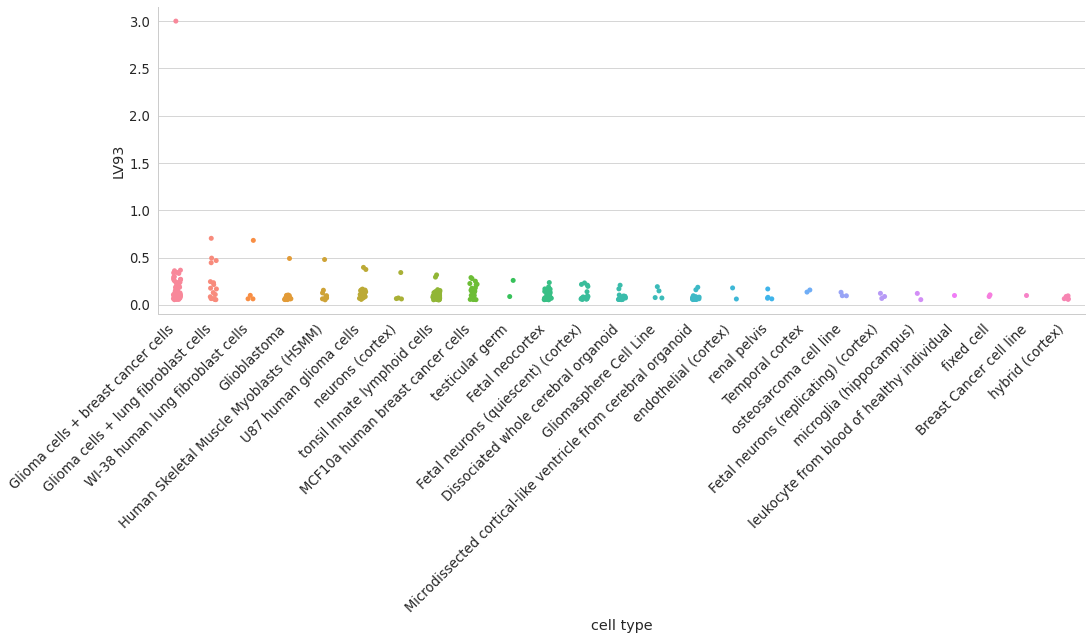

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("neurons")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)